# Проект: Определение токсичности комментариев

## Данные

В наличии были следующие данные о комментариях в интернет-магазине:

- text - текст комментария
- toxic - значение 1, если комментарий является токсичным, значение 0, если не является токсичным

## Задача

Обучить модель для определения токсичности комментариев.

## Используемые библиотеки

pandas, numpy, os, matplotlib, re, nltk, sklearn, pymystem3

## Подготовка

In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk

import re
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from pymystem3 import Mystem


import warnings
warnings.filterwarnings('ignore')

In [4]:
path = '/datasets/toxic_comments.csv'
if not os.path.exists(path):
    path = 'toxic_comments.csv'
    
data = pd.read_csv(path)

In [5]:
data.head(20)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
data = data.drop('Unnamed: 0', axis=1) # Удаление неинформативного признака

In [8]:
data.duplicated().sum() # Проверка на явные дубликаты

0

In [9]:
# Подсчет пропусков в процентах
pd.DataFrame(data.isna().mean()*100,).style.background_gradient('coolwarm')

,0
text,0.000000
toxic,0.000000


In [10]:
data.groupby('toxic')['toxic'].count() # Подсчет количества токсичных и нетоксичных текстов 

toxic
0    143106
1     16186
Name: toxic, dtype: int64

Классы несбалансированны

In [11]:
data['text_len'] = data['text'].apply(lambda x: len(x)) # Добавление столбца с длиной каждого текста

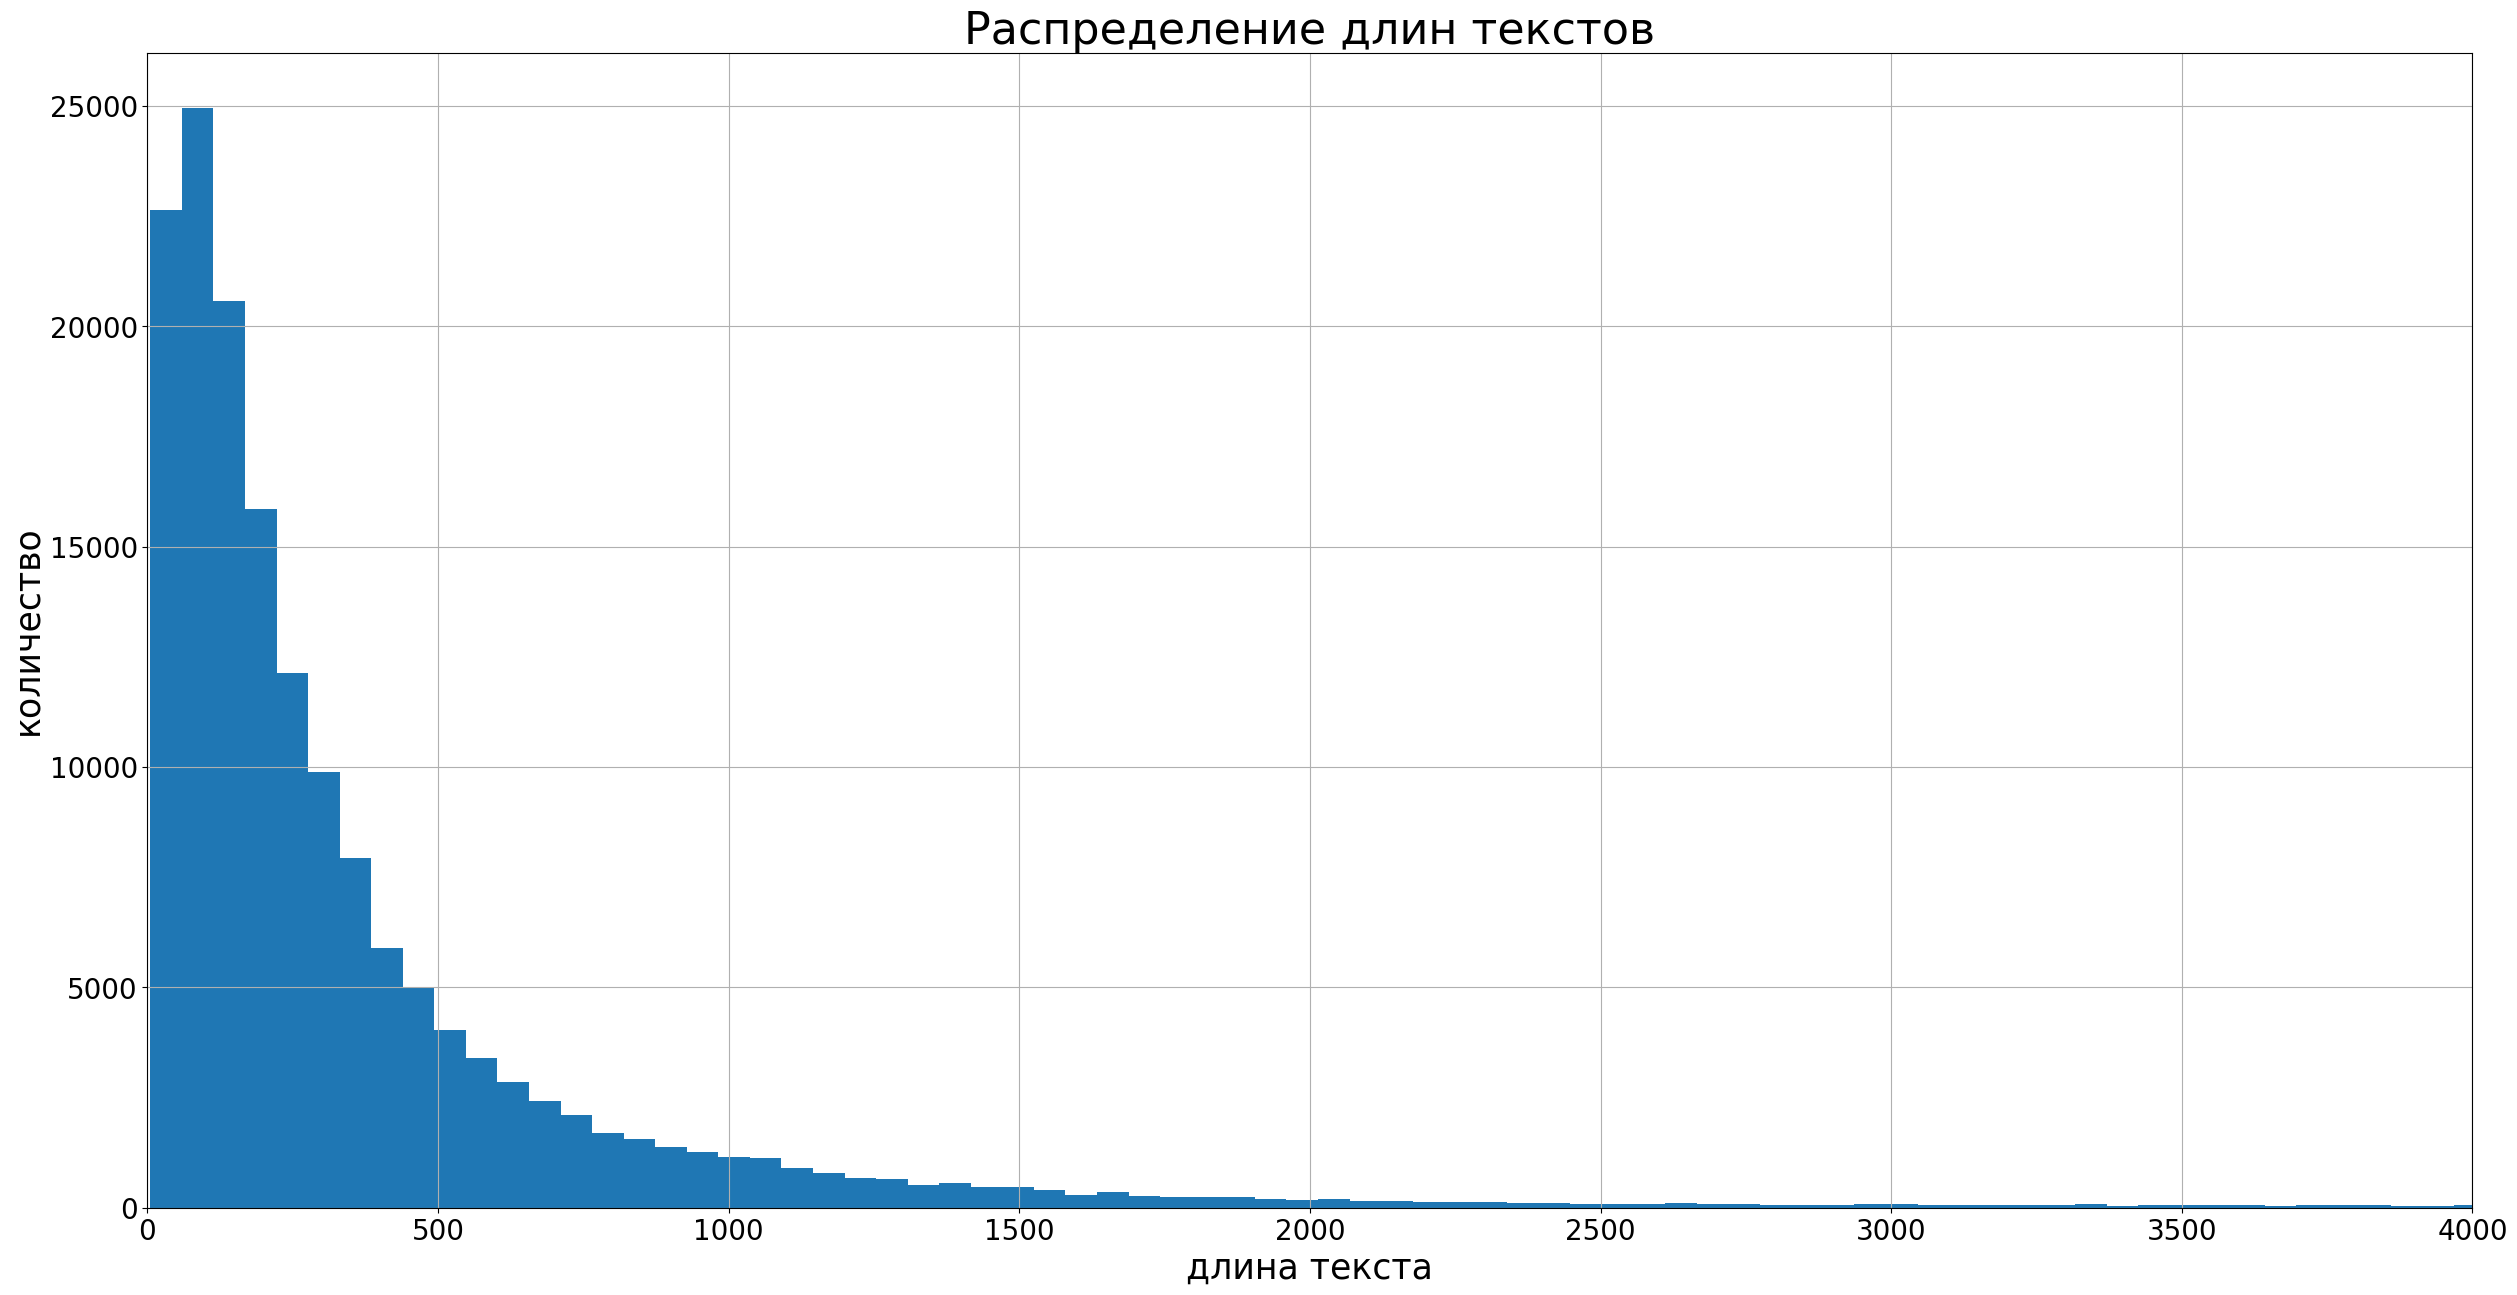

In [12]:
plt.figure(figsize=(30, 15))
data['text_len'].hist(bins=92)
plt.title('Распределение длин текстов', fontsize=32)
plt.xlim(0,4000)
plt.xlabel("длина текста", fontsize=25)
plt.ylabel("количество", fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

Большая часть текстов имеют меньше 600 символов. Некоторые тексты имеют более 2500 символов.

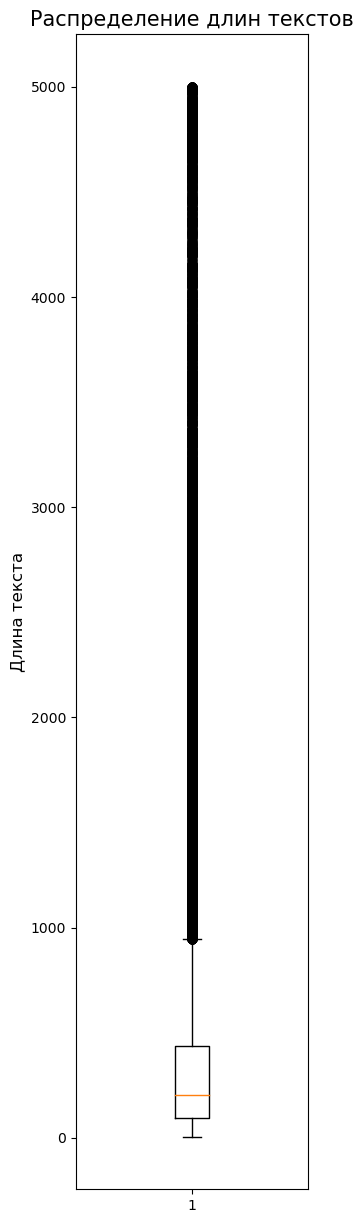

In [13]:
plt.rcParams["figure.figsize"] = (3,15) 

plt.boxplot(data['text_len'])
plt.title('Распределение длин текстов', fontsize=15)
plt.ylabel("Длина текста", fontsize=12)
plt.show()

Огромное количество очень длинных текстов, которые могут оказаться спамом. Сервису стоит задуматься об ограничении количества символов для комментариев пользователей, что может сделать комментарии более информативными.

In [14]:
data.loc[data['text_len'] > 1000, 'text'].unique() # Просмотр текстов, содержащих более 1000 символов


array(['"\nFair use rationale for Image:Wonju.jpg\n\nThanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.\n\nPlease go to the image description page and edit it to include a fair use rationale.\n\nIf you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of \'image\' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking

Тексты содержат большое количество лишних символов и слов, которые следует удалить перед обучением.

In [15]:
# снимаем ограничения в pandas на количество выводимых рядов и колонок,
# а также на ширину колонок
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
 
# загружаем стоп-слова для английского языка
stop_words = stopwords.words('english')

# Функция для очистки текста 
def clean_text(text):
    '''
    Возвращает очищенный от стоп-слов, символов, лишних пробелов текст
    '''
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\br \*+\#+\,\№\[\]\_\-+\+\=+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, ' ', text)
    text = re.sub(r'\wbr\w', ' ', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'URL', text)
    # заменяем числа и цифры на ' NUM '
    #text = re.sub(r'(\d+\s\d+)|(\d+)',' ', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # tokenization
    text = word_tokenize(text)       
    # удаление стоп-слов
    text = [word for word in text if word not in stop_words] 
    text = " ".join(text)
    return text

In [16]:
data['processed_text'] = data['text'].apply(clean_text) # Добавление столбца с очищенным текстом

Процесс лемматизации на локальном компьютере занимает много времени. Хотя для получения результата от одного текста, даже большого (3-4 тысячи символов), PyMystem3 требуется около 1 секунды. Поэтому принято решение обьединить тексты спец. символом, по которому затем тексты заново разделяются. Обьединение по 1000 текстов с разделителем между ними — «br» позволило провезти лемматизацию быстрее.

In [17]:
m = Mystem() # инициализируем лемматайзер 

def lemmatizing(texts):
    ''' Соединяет 10000 текстов в один с разделителем br, лемматизирует, разделяет, возвращает лемматизированный текст. '''
    lol = lambda lst, sz: [lst[i:i+sz] for i in range(0, len(lst), sz)]
    txtpart = lol(texts, 10000)
    res = []
    for txtp in txtpart:
        alltexts = ' '.join([txt + ' br ' for txt in txtp]) # 

        words = m.lemmatize(alltexts)
        doc = []
        for txt in words:
            if txt != '\n' and txt.strip() != '':
                if txt == 'br':
                    res.append(doc)
                    doc = []
                else:
                    doc.append(txt)
    return res

In [18]:
processed = lemmatizing(data['processed_text'])

In [19]:
processed

[['explanation',
  'edits',
  'made',
  'unde',
  'use',
  'name',
  'ha',
  'dco',
  'e',
  'metallica',
  'fan',
  'e',
  'eve',
  'ted',
  'en',
  'vandalisms',
  'closu',
  'e',
  'gas',
  'afte',
  'voted',
  'new',
  'yo',
  'k',
  'dolls',
  'fac',
  'please',
  'emove',
  'template',
  'f',
  'om',
  'talk',
  'page',
  'since',
  'eti',
  'ed'],
 ['aww',
  'matches',
  'backg',
  'ound',
  'colou',
  'seemingly',
  'stuck',
  'thanks',
  'talk',
  'janua',
  'utc'],
 ['hey',
  'man',
  'eally',
  'ying',
  'edit',
  'wa',
  'guy',
  'constantly',
  'emoving',
  'elevant',
  'info',
  'mation',
  'talking',
  'th',
  'ough',
  'edits',
  'instead',
  'talk',
  'page',
  'seems',
  'ca',
  'e',
  'mo',
  'e',
  'fo',
  'matting',
  'actual',
  'info'],
 ['mo',
  'e',
  'make',
  'eal',
  'suggestions',
  'imp',
  'ovement',
  'wonde',
  'ed',
  'section',
  'statistics',
  'late',
  'subsection',
  'types',
  'accidents',
  'think',
  'efe',
  'ences',
  'may',
  'need',
  'tidy

In [20]:
for index in range(len(processed)):
    processed[index] = " ".join(processed[index])
    

In [21]:
processed

['explanation edits made unde use name ha dco e metallica fan e eve ted en vandalisms closu e gas afte voted new yo k dolls fac please emove template f om talk page since eti ed',
 'aww matches backg ound colou seemingly stuck thanks talk janua utc',
 'hey man eally ying edit wa guy constantly emoving elevant info mation talking th ough edits instead talk page seems ca e mo e fo matting actual info',
 'mo e make eal suggestions imp ovement wonde ed section statistics late subsection types accidents think efe ences may need tidying e exact fo mat ie date fo mat etc late one else fi st p efe ences fo fo matting style efe ences want self please let know e appea backlog ticles fo eview guess e may delay eviewe tu ns listed elevant fo eg wikipedia good ticle nominations anspo',
 'si e chance emembe page',
 'cong atulations f om well use tools well talk',
 'cocksucke befo e piss ound wo k',
 'vandalism matt shi vington ticle eve ted please banned',
 'wo nonsense offensive anyway intending w 

In [22]:
data['processed_text_lemmatized'] = processed # Создание столбца с лемматизированными текстами

Тексты очищены от лишних символов, лишних пробелов и знаков пунктуации, стоп-слов, токенизированы, лемматизированы. 

## Обучение

In [23]:
# Разделение на выборки
data_train_valid, data_test = train_test_split(data, test_size=0.1, random_state=12345, shuffle=False)
data_train, data_valid = train_test_split(data_train_valid, test_size=0.11, random_state=12345, shuffle=False)

In [24]:
# Расчет TF-IDF для каждого текста
count_tf_idf = TfidfVectorizer() 
tf_idf = count_tf_idf.fit(data_train['processed_text_lemmatized']) 

In [25]:
features_train = count_tf_idf.transform(data_train['processed_text_lemmatized']) 
features_valid = count_tf_idf.transform(data_valid['processed_text_lemmatized']) 
features_test = count_tf_idf.transform(data_test['processed_text_lemmatized']) 

target_train = data_train['toxic']
target_valid = data_valid['toxic']
target_test = data_test['toxic']

In [28]:
%%time
dummy_regr = DummyClassifier(strategy="uniform") # Константная модель
dummy_regr.fit(features_train, target_train)
predictions = dummy_regr.predict(features_valid)
print("Accuracy:", accuracy_score(predictions, target_valid))
print("F1:", f1_score(predictions, target_valid))

Accuracy: 0.4989854153455929
F1: 0.1631183137379515
CPU times: user 11.1 ms, sys: 7.69 ms, total: 18.7 ms
Wall time: 21.8 ms


In [29]:
# Логистическая регрессия
clf = GridSearchCV(cv=3, scoring='f1',
       estimator=LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
       intercept_scaling=1, max_iter=1500, multi_class='ovr', n_jobs=1,
       penalty='l1', random_state=None, solver='lbfgs', tol=0.0001,
       verbose=0, warm_start=False),n_jobs=1,
       param_grid={'C': [1, 5, 10, 15], 'penalty':['l1', 'l2', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, verbose=0)

In [30]:
clf.fit(features_train, target_train)
print(clf.best_estimator_)
print(clf.best_params_)
print("F1:",clf.best_score_)

LogisticRegression(C=10, class_weight='balanced', max_iter=1500,
                   multi_class='ovr', n_jobs=1)
{'C': 10, 'penalty': 'l2'}
F1: 0.747726236850717


In [33]:
%%time
neigh = KNeighborsClassifier(n_neighbors=5) # KNeighborsClassifier
neigh.fit(features_train, target_train)
predictions = neigh.predict(features_valid)
score = f1_score(target_valid, predictions)
print("F1:", score)

F1: 0.2853133769878391
CPU times: user 40 s, sys: 11.3 s, total: 51.3 s
Wall time: 52.3 s


In [34]:
%%time
best_est = 0 # Подбор гиперпараметров для Модели случайного леса
best_depth = 0
min_score = 0.1
best_model_forest_classifier = None
for est in range(5, 46, 10):
    for depth in range (6, 21,2):
        model_forest_classifier = RandomForestClassifier(random_state=12345,n_estimators=est,max_depth=depth,class_weight='balanced')
        model_forest_classifier.fit(features_train, target_train)
        predictions = model_forest_classifier.predict(features_valid)
        score = f1_score(target_valid, predictions)
        if abs(score) > abs(min_score):
            min_score = score
            best_depth = depth
            best_est = est
            best_model_forest_classifier = model_forest_classifier
print("F1 наилучшей модели RandomForestRegressor:", (abs(min_score)), "Количество деревьев:", best_est, "Глубина дерева:", best_depth)


F1 наилучшей модели RandomForestRegressor: 0.360887381658895 Количество деревьев: 45 Глубина дерева: 20
CPU times: user 40.2 s, sys: 195 ms, total: 40.4 s
Wall time: 40.4 s


In [35]:
predictions = clf.best_estimator_.predict(features_test)
print("Accuracy:", accuracy_score(predictions, target_test))
print("F1:", f1_score(predictions, target_test))

Accuracy: 0.9446955430006277
F1: 0.7517610594533671


## Выводы

<p>Предобработка: удален неиформативный столбец Unnamed: 0. Явные дубликаты и пропуски отсутствуют. Тексты очищены от лишних символов, лишних пробелов и знаков пунктуации, стоп-слов, токенизированы, лемматизированы. Для каждого текста рассчитано TF-IDF(признаки для классификации). </p>

<p>Обучены модели - Логистическая регрессия, Случайный лес, KNeighborsClassifier. </p>
<p><b> наилучшей моделью является Логистическая регрессия, именно ее следует использовать заказчику. F1: 0.75176 </b> </p>
 